In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron

In [2]:
data = pd.read_csv("gait.csv")

In [3]:
df = data.copy()

In [4]:
df

,subject,condition,replication,leg,joint,time,angle
0,1,1,1,1,1,0,4.682881
1,1,1,1,1,1,1,5.073127
2,1,1,1,1,1,2,5.229774
3,1,1,1,1,1,3,5.083273
4,1,1,1,1,1,4,4.652399
...,...,...,...,...,...,...,...
181795,10,3,10,2,3,96,29.778412
181796,10,3,10,2,3,97,29.247559
181797,10,3,10,2,3,98,28.796951
181798,10,3,10,2,3,99,28.432936


In [5]:
df.shape    #181800 -- rows , 7 -- columns

(181800, 7)

In [6]:
df = df.reindex(columns=['subject', 'replication','leg', 'joint','time', 'angle','condition'])

In [7]:
df #reindexed cols

,subject,replication,leg,joint,time,angle,condition
0,1,1,1,1,0,4.682881,1
1,1,1,1,1,1,5.073127,1
2,1,1,1,1,2,5.229774,1
3,1,1,1,1,3,5.083273,1
4,1,1,1,1,4,4.652399,1
...,...,...,...,...,...,...,...
181795,10,10,2,3,96,29.778412,3
181796,10,10,2,3,97,29.247559,3
181797,10,10,2,3,98,28.796951,3
181798,10,10,2,3,99,28.432936,3


In [8]:
df.isna().sum() #no Nan Values

subject        0
replication    0
leg            0
joint          0
time           0
angle          0
condition      0
dtype: int64

In [9]:
condition_map = {1: 0, 2 : 1,3 : 2}
df['condition'] = df['condition'].map(condition_map)   #mapping target column as 1: 0, 2 : 1,3 : 2 (condition)

In [10]:
df.shape

(181800, 7)

In [11]:
X = df.iloc[:,0:-1]   # subject replication leg joint time angle
y = df.iloc[:,-1]     # condition

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [25]:
x_main = [X_train]
print(X_train)
print(X_test.shape)

        subject  replication  leg  joint  time      angle
135281        8            4    1      2    42  12.837695
36836         3            1    2      2    72  62.860972
145502        9            1    1      1    62   7.178063
171153       10            3    1      3    59  -6.911891
65969         4            9    2      3    16  17.783626
...         ...          ...  ...    ...   ...        ...
131231        8            7    2      1    32   8.160843
103175        6            1    1      2    54  15.966955
83928         5            9    1      3    98  27.180625
58604         4            7    2      2    24   5.173512
27432         2            6    1      2    61  27.118325

[127260 rows x 6 columns]
(54540, 6)


# RandomForestClassifier

In [14]:
pipe = Pipeline([
    ('scaler', StandardScaler()),                      #first it will standardize the data then 
    ('pca', PCA(n_components = 5)),                                    #it will reduce the dimensions
    ('classifier', SVC())                              #then it will apply svm taking too much time
])
param_grid = {
    'n_estimators': [120],
    'max_depth': [30],
    'min_samples_split': [10]
}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2)
grid_search.fit(X, y)

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [30], 'min_samples_split': [10],
                         'n_estimators': [120]})

In [16]:
y_pred = grid_search.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))

Accuracy score: 0.9234873487348735


# Support vector time Taking

# LOGISTIC REGRESSION

In [17]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('logreg', LogisticRegression(multi_class='multinomial', solver='lbfgs'))
])

param_grid = {
    'pca__n_components': [6],
    'logreg__C': [1],
    'logreg__penalty': ['l2']
}

grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'logreg__C': 1, 'logreg__penalty': 'l2', 'pca__n_components': 6}
0.3742024202420242


In [18]:
y_pred = grid.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))

Accuracy score: 0.3746607994132747


# Neural Network

In [19]:
from keras.models import Sequential
from keras.layers import Dense

# Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=6)),
    ('model', Sequential([
        Dense(64, input_dim=6, activation='relu'),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ]))
])

# Compile the model
pipeline.named_steps['model'].compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
pipeline.fit(X_train, y_train, model__epochs=20, model__batch_size=80, model__validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = pipeline.named_steps['model'].evaluate(X_test, y_test)
print('Accuracy:', accuracy)


# Use the model for prediction
#X_new = np.random.rand(5, 10)
#y_pred = pipeline.predict(X_new)
#print(y_pred)

Epoch 1/20
1591/1591 [==============================] - 6s 4ms/step - loss: 1.0403 - accuracy: 0.4190 - val_loss: 40.2740 - val_accuracy: 0.3472
Epoch 2/20
1591/1591 [==============================] - 4s 2ms/step - loss: 1.0020 - accuracy: 0.4456 - val_loss: 59.7186 - val_accuracy: 0.3489
Epoch 3/20
1591/1591 [==============================] - 8s 5ms/step - loss: 0.9798 - accuracy: 0.4659 - val_loss: 66.0369 - val_accuracy: 0.3455
Epoch 4/20
1591/1591 [==============================] - 7s 4ms/step - loss: 0.9578 - accuracy: 0.4824 - val_loss: 90.1712 - val_accuracy: 0.3211
Epoch 5/20
1591/1591 [==============================] - 7s 4ms/step - loss: 0.9374 - accuracy: 0.4963 - val_loss: 115.4816 - val_accuracy: 0.3330
Epoch 6/20
1591/1591 [==============================] - 5s 3ms/step - loss: 0.9229 - accuracy: 0.5065 - val_loss: 130.1331 - val_accuracy: 0.3328
Epoch 7/20
1591/1591 [==============================] - 6s 4ms/step - loss: 0.9114 - accuracy: 0.5124 - val_loss: 149.8075 - val

# Naive Bayes

In [20]:
pipe = Pipeline([
    ('scaler', StandardScaler()),                      #first it will standardize the data then 
    ('pca', PCA()),                                    #it will reduce the dimensions
    ('classifier', GaussianNB())                       #then it will apply Naive Bayes
])

param_grid = {
    'pca__n_components': [5],
}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=2, n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'pca__n_components': 5}
0.36904761904761907


In [21]:
y_pred = grid.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))

Accuracy score: 0.3733039970663733


# Perceptron

In [22]:
pipe = Pipeline([
    ('scaler', StandardScaler()), # Apply standard scaling to the features
    ('pca', PCA()), # Reduce the dimensionality using PCA
    ('classifier', Perceptron()) # Use Perceptron as the classifier instead of GaussianNB
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'pca__n_components': [1,2,3,4,5,6], # Tune the number of components for PCA
    'classifier__eta0': [0.01, 0.1, 1], # Tune the learning rate for Perceptron
    'classifier__max_iter': [1000, 2000, 3000] # Tune the maximum number of iterations for Perceptron
}

# Create the GridSearchCV object
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)

# Train the pipeline on the train set using GridSearchCV
grid.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print(grid.best_params_)
print(grid.best_score_)

{'classifier__eta0': 1, 'classifier__max_iter': 1000, 'pca__n_components': 2}
0.3401933050447902


In [96]:
y_pred = grid.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))

Accuracy score: 0.33562522918958565


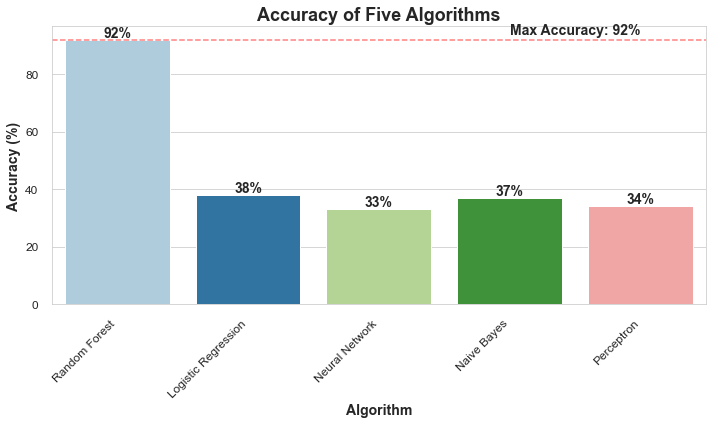

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a list of algorithms and their accuracy
algorithms = ['Random Forest', 'Logistic Regression', 'Neural Network', 'Naive Bayes', 'Perceptron']
accuracy = [92, 38, 33, 37, 34]

# Create a dictionary with the data
data = {'Algorithm': algorithms, 'Accuracy': accuracy}

# Convert the dictionary to a Pandas DataFrame
df = pd.DataFrame(data)

# Set the style of the plot
sns.set_style('whitegrid')
sns.set_palette('Paired')

# Set the figure size
plt.figure(figsize=(10,6))

# Create a bar plot using Seaborn
ax = sns.barplot(x='Algorithm', y='Accuracy', data=df)

# Add labels to the plot
ax.set_title('Accuracy of Five Algorithms', fontsize=18, fontweight='bold')
ax.set_xlabel('Algorithm', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.tick_params(axis='both', labelsize=12, pad=10)

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Add text annotations to the bars
for i in range(len(algorithms)):
    ax.text(i, accuracy[i]+1, str(accuracy[i])+'%', ha='center', fontsize=14, fontweight='bold')

# Add a horizontal line to the plot
ax.axhline(y=max(accuracy), color='red', alpha=0.5, linestyle='--')
ax.text(len(algorithms)-1, max(accuracy)+1, 'Max Accuracy: '+str(max(accuracy))+'%', ha='right', va='bottom', fontsize=14, fontweight='bold')

# Display the plot
plt.tight_layout()
plt.show()